In [ ]:
pip install brian2

# Libraries

In [510]:
from brian2 import *
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Network Initialization

In [511]:

start_scope()
N = 10


#Neuron Group Parameters
tau = 60*ms
v_rest = -65*mV
v_reset = -65*mV
v_threshold = -55*mV
refractory_period = 5*ms

#LIF equation
eqs = '''
dv/dt = (v_rest - v + I) / tau : volt (unless refractory)
I : volt
x : metre
y : metre
'''

N_excitatory = 8
N_inhibitory = 2
N_total = N_excitatory + N_inhibitory

G = NeuronGroup(N_total, model=eqs, threshold='v > v_threshold', reset='v = v_reset',
                refractory=refractory_period, method='exact')
G.v = v_rest
G.I = 0*mV
neuron_spacing = 50 * metre


np.random.seed(3)
neuron_positions_x = np.random.rand(N_total) * neuron_spacing
neuron_positions_y = np.random.rand(N_total) * neuron_spacing
width = max(neuron_positions_x)

height = max(neuron_positions_y)
G.x = neuron_positions_x
G.y = neuron_positions_y

#Excitatory and Inhibitory Neuron Split
exc_neurons = G[:N_excitatory]
inh_neurons = G[N_excitatory:]


#STDP Parameters
tau_stdp =15*ms
Aplus = 0.1
Aminus = -Aplus

#STDP Equation
stdp_eqs = '''
w : 1
dApre/dt = -Apre / tau_stdp : 1 (event-driven)
dApost/dt = -Apost / tau_stdp : 1 (event-driven)
'''

pre_eqs_exc = '''
I_post += w*mV
Apre += Aplus
w = clip(w + Apost, 0, 1)
'''
post_eqs_exc = '''
Apost += Aminus
w = clip(w + Apre, 0, 1)
'''

pre_eqs_inh = '''
I_post -= w*mV
Apre += Aplus
w = clip(w + Apost, 0, 1)
'''
post_eqs_inh = '''
Apost += Aminus
w = clip(w + Apre, 0, 1)
'''


def connection_probability(x_pre, y_pre, x_post, y_post, width):
    return np.exp(-4*((x_pre - x_post)**2 + (y_pre - y_post)**2) / (width**2))

conn_matrix_exc = np.zeros((N_excitatory, N_total))

for i in range(N_excitatory):
    for j in range(N_total):
        conn_matrix_exc[i, j] = connection_probability(G.x[i], G.y[i], G.x[j], G.y[j], width)

S_exc = Synapses(exc_neurons, G, model=stdp_eqs, on_pre=pre_eqs_exc, on_post=post_eqs_exc)
for i in range(N_excitatory):
    for j in range(N_total):
        if np.random.rand() < conn_matrix_exc[i, j]:
            if i != j: 
                S_exc.connect(i=i, j=j)
S_exc.w = '0.5*rand()'

conn_matrix_inh = np.zeros((N_inhibitory, N_total))
for i in range(N_inhibitory):
    for j in range(N_total):
        conn_matrix_inh[i, j] = connection_probability(G.x[N_excitatory + i], G.y[N_excitatory + i], G.x[j], G.y[j], width)

S_inh = Synapses(inh_neurons, G, model=stdp_eqs, on_pre=pre_eqs_inh, on_post=post_eqs_inh)

for i in range(N_inhibitory):
    for j in range(N_total):
        if np.random.rand() < conn_matrix_inh[i, j]:
            if i != j: 
                S_inh.connect(i=i, j=j)
S_inh.w = '0.5*rand()'



In [512]:
print(S_inh.connect())

None


# Input Preprocessing

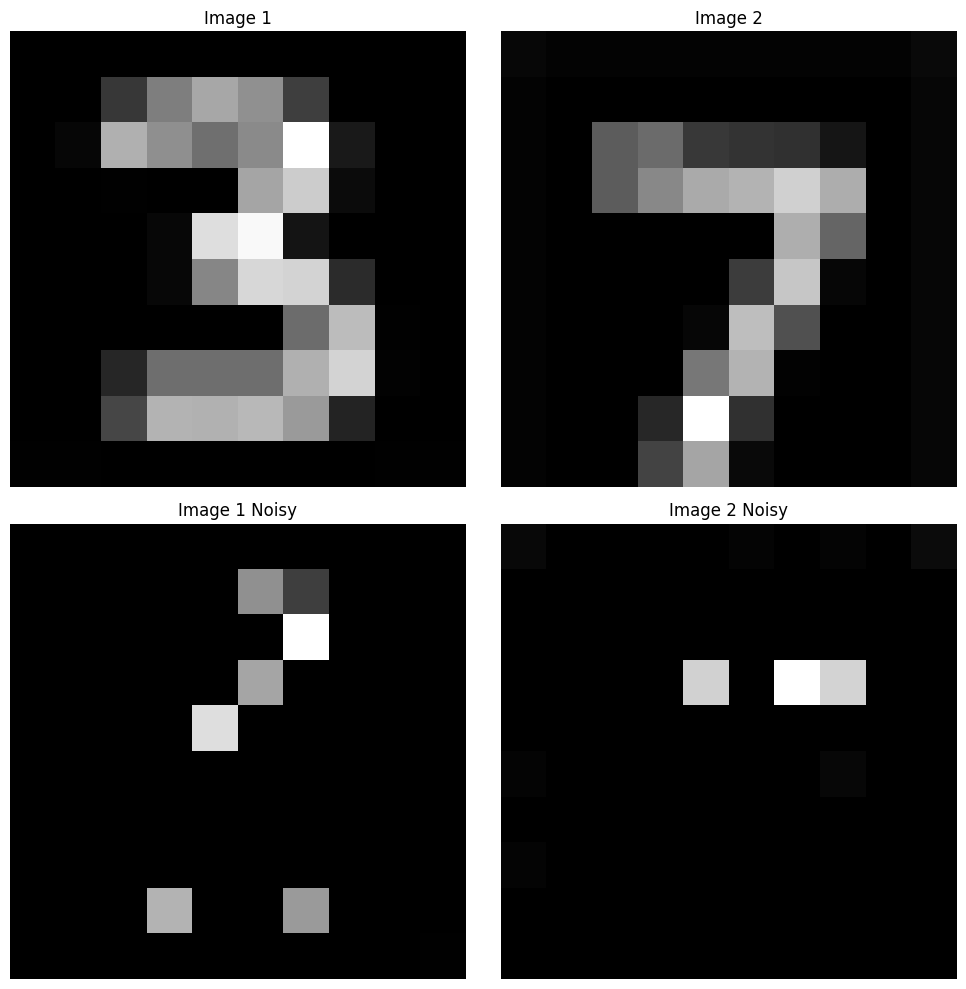

In [513]:
def preprocess_image(image_path, size):
    image = Image.open(image_path).convert('L')  
    image = image.resize(size)  
    image_array = np.array(image)
    image_array = image_array / 255.0 
    return image_array

def preprocess_image_noisy(image_path, size,salt_prob, pepper_prob):
    image = Image.open(image_path).convert('L')  
    image = image.resize(size)  
    image_array = np.array(image)
    random_matrix = np.random.rand(*image_array.shape[:2])

    salt_mask = random_matrix < salt_prob
    image_array[salt_mask] = 0
    image_array = image_array / 255.0  
    return image_array

defaultclock.dt = 1*ms
salt_prob = 0.8 
pepper_prob = 0.03  


image_size = (10, 10) 
image1_array = preprocess_image('3.png', image_size)
image2_array = preprocess_image('7.png', image_size)
image3_array = preprocess_image_noisy('3.png', image_size ,salt_prob, pepper_prob)
image4_array = preprocess_image_noisy('7.png', image_size ,salt_prob, pepper_prob)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].imshow(image1_array, cmap='gray')
axs[0, 0].set_title("Image 1")
axs[0, 0].axis('off')
axs[0, 1].imshow(image2_array, cmap='gray')
axs[0, 1].set_title("Image 2")
axs[0, 1].axis('off')
axs[1, 0].imshow(image3_array, cmap='gray')
axs[1, 0].set_title("Image 1 Noisy")
axs[1, 0].axis('off')
axs[1, 1].imshow(image4_array, cmap='gray')
axs[1, 1].set_title("Image 2 Noisy")
axs[1, 1].axis('off')
plt.tight_layout()
plt.show()

def aggregate_image(image_array):
    assert image_array.shape == (10, 10), "Image must be 10x10"
    aggregated_values = np.mean(image_array.reshape(10, 10), axis=1)
    return aggregated_values

def image_to_spike_times(aggregated_values, max_firing_rate, duration):
    indices = []
    times = []
    for i, value in enumerate(aggregated_values):

        num_spikes = int(value * max_firing_rate * duration)
        np.set_printoptions(precision=3)

        if num_spikes > 0:
            spike_times = np.round(np.random.uniform(low = 0.001, high=duration, size=num_spikes),3)
            spike_times = np.unique(spike_times)
            for t in spike_times:
                
                indices.append(i)
                times.append(t)
    return indices, times


aggregated1_values = aggregate_image(image1_array)
aggregated2_values = aggregate_image(image2_array)
aggregated3_values = aggregate_image(image3_array)
aggregated4_values = aggregate_image(image4_array)

#Spike Time Parameters
max_firing_rate = 1000 * Hz
duration = 100 * ms

indices1, times1 = image_to_spike_times(aggregated1_values, max_firing_rate, duration)
indices2, times2 = image_to_spike_times(aggregated2_values, max_firing_rate, duration)
indices_noisy1, times_noisy1 = image_to_spike_times(aggregated3_values, max_firing_rate, duration)
indices_noisy2, times_noisy2 = image_to_spike_times(aggregated4_values, max_firing_rate, duration)

for i in range(len(times2)):
    times2[i] = times2[i] + 0.1
times3= []
indices3 = []
for i in range(len(times1)):
    times3.append(times1[i]+0.2)
    indices3.append(indices1[i])
times4= []
indices4 = []
for i in range(len(times2)):
    times4.append(times2[i]+0.2)
    indices4.append(indices2[i])
times5= []
indices5 = []
for i in range(len(times1)):
    times5.append(times1[i]+0.4)
    indices5.append(indices1[i])
times6= []
indices6 = []
for i in range(len(times2)):
    times6.append(times2[i]+0.4)
    indices6.append(indices2[i])
times7= []
indices7 = []
for i in range(len(times_noisy1)):
    times7.append(times_noisy1[i]+1.6)
    indices7.append(indices_noisy1[i])
times8= []
indices8= []
for i in range(len(times_noisy2)):
    times8.append(times_noisy2[i]+2.0)
    indices8.append(indices_noisy2[i])

times9= []
indices9 = []
for i in range(len(times1)):
    times9.append(times1[i]+0.8)
    indices9.append(indices1[i])
times10= []
indices10= []
for i in range(len(times2)):
    times10.append(times2[i]+1.2)
    indices10.append(indices2[i])


#Input Group
input_group = SpikeGeneratorGroup(10, indices1+indices2+indices3+indices4+indices5+indices6+indices9+indices10+indices8+indices7, (times1+ times2+times3+ times4+times5 + times6+times9+times10+times8+times7) * second)


# Simulation

In [514]:


input_syn = Synapses(input_group, G, on_pre='v += 2*mV')
input_syn.connect(j='i')

weight_monitor_exc = StateMonitor(S_exc, 'w', record=True)
weight_monitor_inh = StateMonitor(S_inh, 'w', record=True)
spike_monitor = SpikeMonitor(G)
weight_monitor_exc = StateMonitor(S_exc, 'w', record=True)
weight_monitor_inh = StateMonitor(S_inh, 'w', record=True)
spike_monitor = SpikeMonitor(G)
voltage_monitor = StateMonitor(G, 'v', record=True) 

run(2100*ms)


# Result Plots

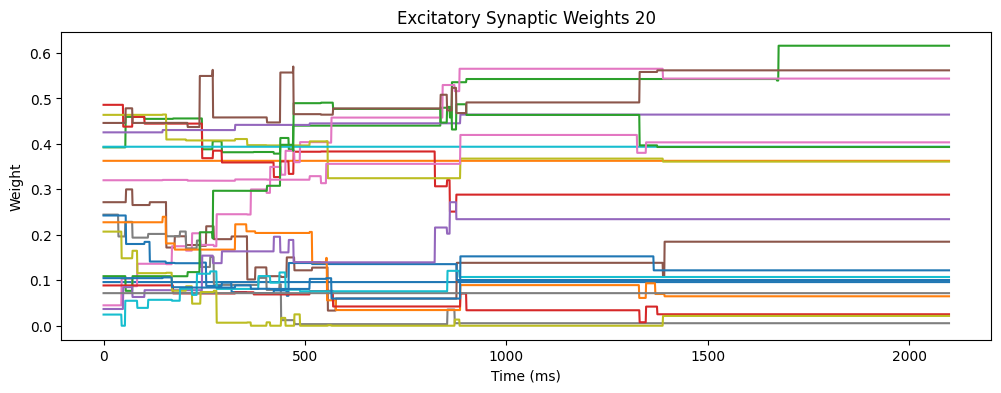

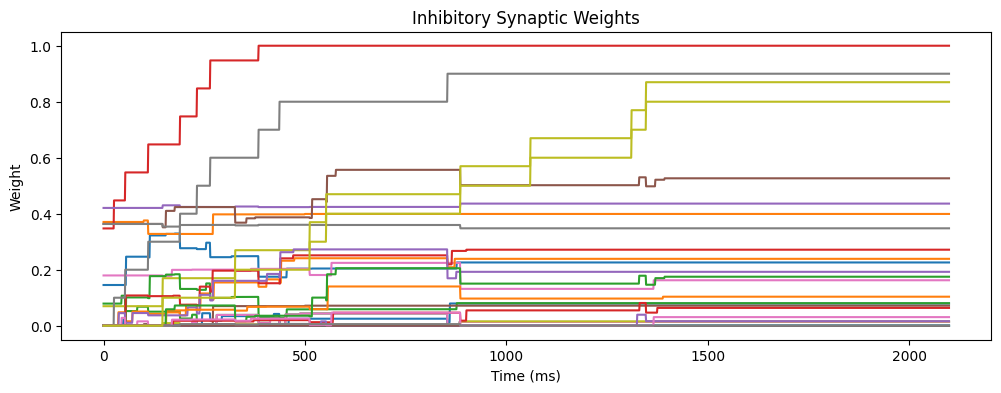

In [515]:

figure(figsize=(12, 4))
for i in range(len(weight_monitor_exc.w)):  
    plot(weight_monitor_exc.t/ms, weight_monitor_exc.w[i], label=f'Excitatory synapse {i}')
    xlabel('Time (ms)')
    ylabel('Weight')
    title(F'Excitatory Synaptic Weights {i}')
show()


figure(figsize=(12, 4))
for i in range(len(weight_monitor_inh.w)):
    plot(weight_monitor_inh.t/ms, weight_monitor_inh.w[i], label=f'Inhibitory synapse {i}')
xlabel('Time (ms)')
ylabel('Weight')
title('Inhibitory Synaptic Weights')

show()



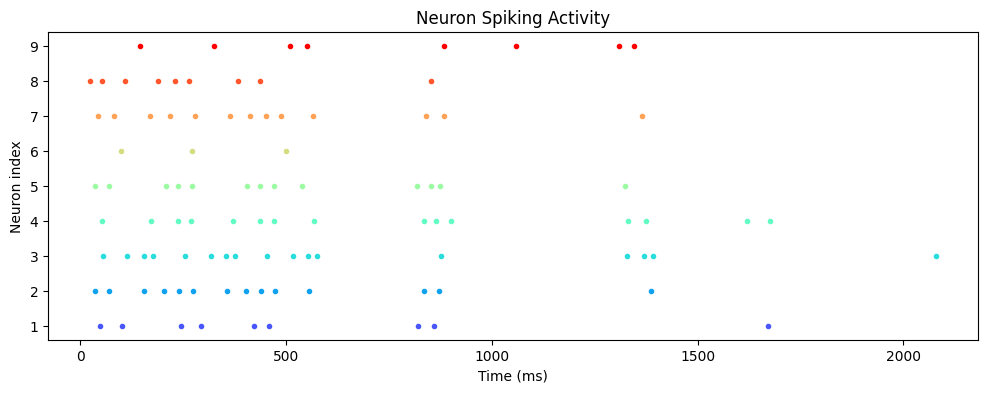

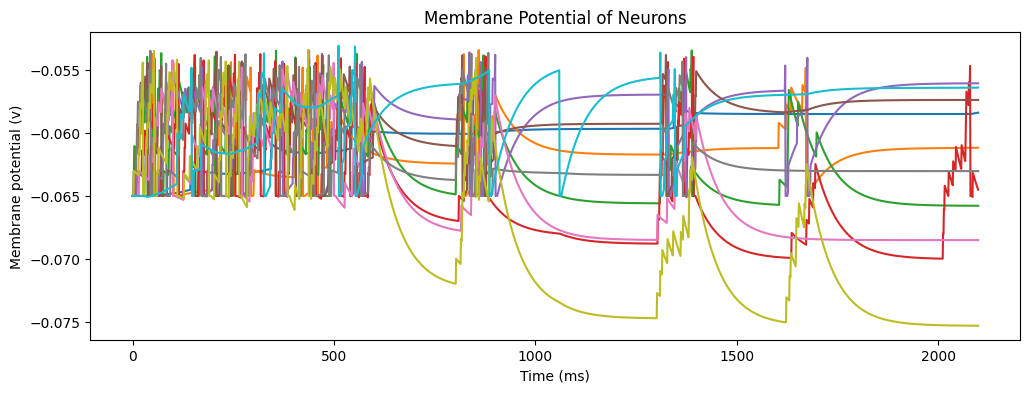

In [516]:
figure(figsize=(12, 4))
colors = matplotlib.cm.rainbow(np.linspace(0, 1, N))

for i in range(N_total):
    neuron_spikes = spike_monitor.t[spike_monitor.i == i]
    plt.plot(neuron_spikes/ms, [i]*len(neuron_spikes), '.', color=colors[i], label=f'Neuron {i}')
xlabel('Time (ms)')
ylabel('Neuron index')
title('Neuron Spiking Activity')
show()


figure(figsize=(12, 4))
for i in range(len(voltage_monitor.v)):

    plot(voltage_monitor.t/ms, voltage_monitor.v[i], label=f'Neuron {i}')
    xlabel('Time (ms)')
    ylabel('Membrane potential (v)')
    title('Membrane Potential of Neurons')
show()

In [517]:
firing_rates = []
duration = 200 * ms
for i in range(N_total):
    firing_rate = sum(spike_monitor.i == i) / (duration / second)
    firing_rates.append(firing_rate)

print("Firing Rates (Hz):", firing_rates)

Firing Rates (Hz): [0.0, 45.0, 70.0, 85.0, 75.0, 65.0, 15.0, 65.0, 45.0, 40.0]


# Network Visualization

WARNING    c:\Users\heypo\AppData\Local\Programs\Python\Python39\lib\site-packages\networkx\drawing\nx_pylab.py:437: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(
 [py.warnings]


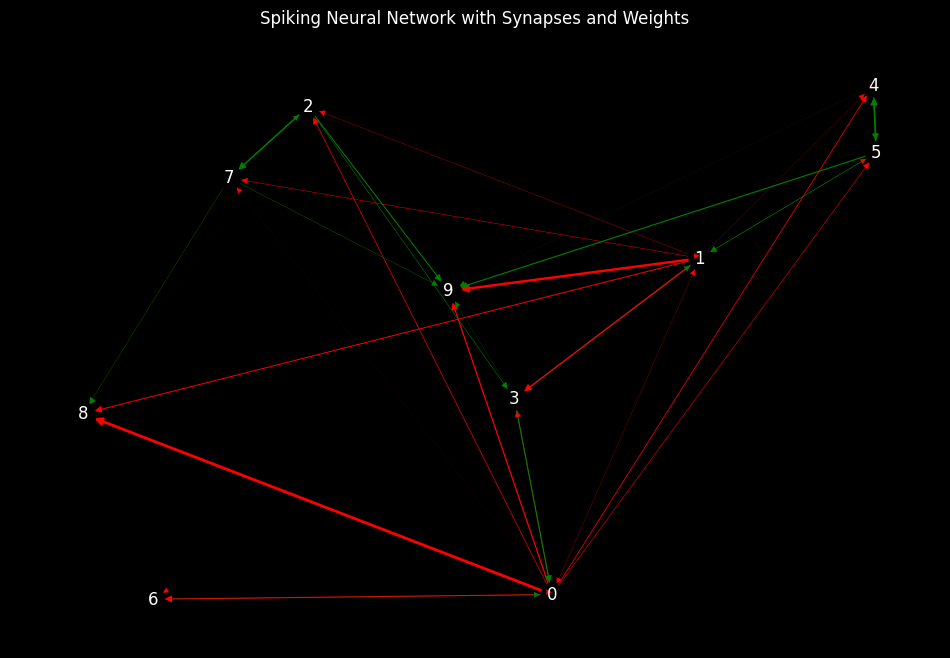

In [518]:
import networkx as nx

neuron_positions = [(G.x[i], G.y[i]) for i in range(N)]

G_graph = nx.DiGraph()

for i, pos in enumerate(neuron_positions):
    G_graph.add_node(i, pos=pos)

#Excitatory Edges
for i, j in zip(S_exc.i[:], S_exc.j[:]):
    G_graph.add_edge(i, j, weight=S_exc.w[i, j], color = 'g')

#Inhibitory Edges
for i, j in zip(S_inh.i[:], S_inh.j[:]):
    G_graph.add_edge(i, j, weight=S_inh.w[i, j], color='r')

pos = nx.get_node_attributes(G_graph, 'pos')
edges = G_graph.edges(data=True)

fig = plt.figure(figsize=(12, 8), )
nx.draw_networkx_nodes(G_graph, pos, node_size=500,node_color=(0, 0, 0, 0))
nx.draw_networkx_labels(G_graph, pos, font_size=12, font_family="sans-serif",font_color='white')


for (u, v, d) in edges:
    width = d['weight'] * 2 
    color = d.get('color', 'b')  #Green for excitatory, Red for inhibitory
    nx.draw_networkx_edges(G_graph, pos, edgelist=[(u, v)], width=width, edge_color=color)

plt.title('Spiking Neural Network with Synapses and Weights', color = 'white')
fig.patch.set_facecolor('black')
plt.axis('off')
plt.show()

# Network Extension 2D

In [544]:
start_scope()
N = 40

#Parameters
tau = 70*ms
v_rest = -65*mV
v_reset = -70*mV
v_threshold = -48*mV
refractory_period = 5*ms

#LIF equation
eqs = '''
dv/dt = (v_rest - v + I) / tau : volt (unless refractory)
I : volt
x : metre
y : metre
'''




N_excitatory = int(0.8*N)
N_inhibitory = int(0.2*N)
N_total = N_excitatory + N_inhibitory

G = NeuronGroup(N_total, model=eqs, threshold='v > v_threshold', reset='v = v_reset',
                refractory=refractory_period, method='exact')
G.v = v_rest
G.I = 0*mV
neuron_spacing = 5*N * metre


np.random.seed(3)
neuron_positions_x = np.random.rand(N_total) * neuron_spacing
neuron_positions_y = np.random.rand(N_total) * neuron_spacing
width = max(neuron_positions_x)

height = max(neuron_positions_y)

G.x = neuron_positions_x
G.y = neuron_positions_y


exc_neurons = G[:N_excitatory]
inh_neurons = G[N_excitatory:]

#STDP Parameters
tau_stdp = 15*ms
Aplus = 0.08
Aminus = -Aplus

#STDP Equation
stdp_eqs = '''
w : 1
dApre/dt = -Apre / tau_stdp : 1 (event-driven)
dApost/dt = -Apost / tau_stdp : 1 (event-driven)
'''


pre_eqs_exc = '''
I_post += w*mV
Apre += Aplus
w = clip(w + Apost, 0, 1)
'''
post_eqs_exc = '''
Apost += Aminus
w = clip(w + Apre, 0, 1)
'''

pre_eqs_inh = '''
I_post -= w*mV
Apre += Aplus
w = clip(w + Apost, 0, 1)
'''
post_eqs_inh = '''
Apost += Aminus
w = clip(w + Apre, 0, 1)
'''


def connection_probability(x_pre, y_pre, x_post, y_post, width):
    return np.exp(-N/2*((x_pre - x_post)**2 + (y_pre - y_post)**2) / (width**2))


conn_matrix_exc = np.zeros((N_excitatory, N_total))

for i in range(N_excitatory):
    for j in range(N_total):
        conn_matrix_exc[i, j] = connection_probability(G.x[i], G.y[i], G.x[j], G.y[j], width)
S_exc = Synapses(exc_neurons, G, model=stdp_eqs, on_pre=pre_eqs_exc, on_post=post_eqs_exc)
for i in range(N_excitatory):
    for j in range(N_total):
        if np.random.rand() < conn_matrix_exc[i, j]:
            if i != j: 
                S_exc.connect(i=i, j=j)
S_exc.w = '0.5*rand()'


conn_matrix_inh = np.zeros((N_inhibitory, N_total))
for i in range(N_inhibitory):
    for j in range(N_total):
        conn_matrix_inh[i, j] = connection_probability(G.x[N_excitatory + i], G.y[N_excitatory + i], G.x[j], G.y[j], width)

S_inh = Synapses(inh_neurons, G, model=stdp_eqs, on_pre=pre_eqs_inh, on_post=post_eqs_inh)
for i in range(N_inhibitory):
    for j in range(N_total):
        if np.random.rand() < conn_matrix_inh[i, j]:
            if i != j: 
                S_inh.connect(i=i, j=j)
S_inh.w = '0.5*rand()'




# Input Preprocessing II

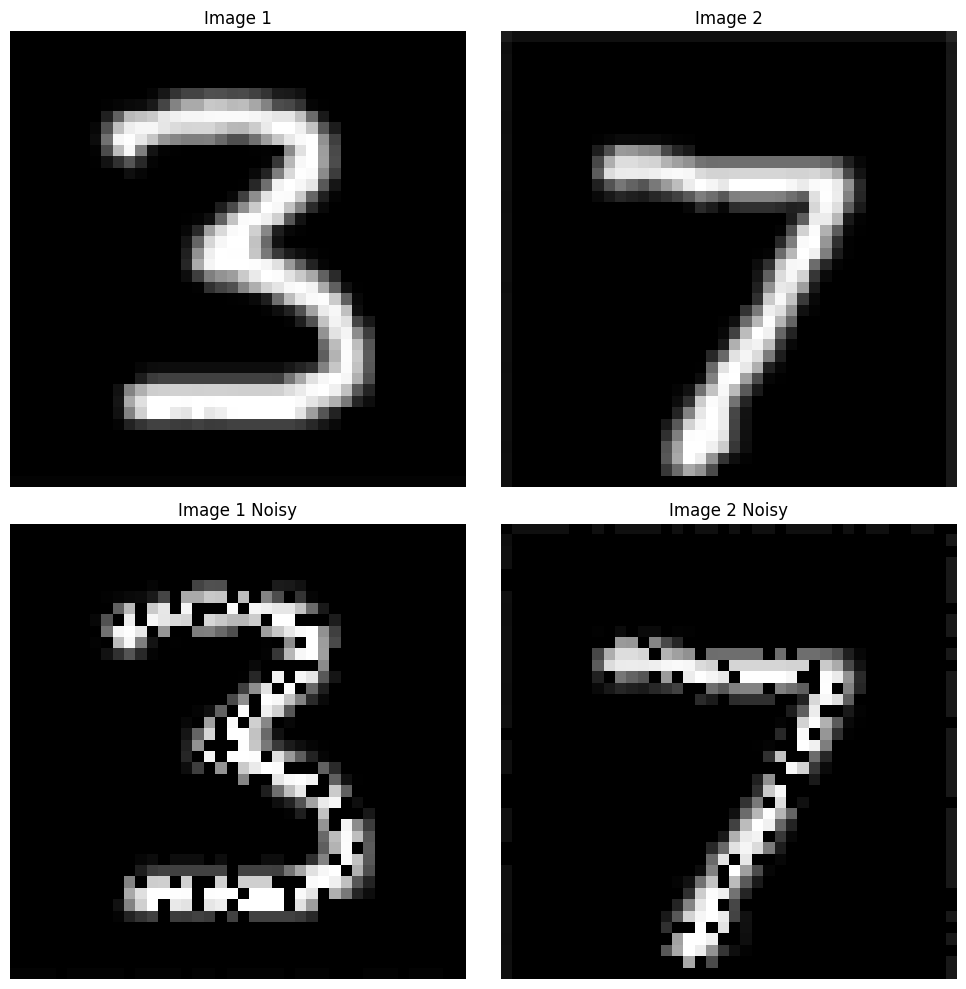

In [545]:
def preprocess_image(image_path, size):
    image = Image.open(image_path).convert('L')  
    image = image.resize(size)  
    image_array = np.array(image)
    image_array = image_array / 255.0  
    return image_array

def preprocess_image_noisy(image_path, size,salt_prob, pepper_prob):
    image = Image.open(image_path).convert('L')  
    image = image.resize(size)  
    image_array = np.array(image)
    random_matrix = np.random.rand(*image_array.shape[:2])

    salt_mask = random_matrix < salt_prob
    image_array[salt_mask] = 0

    image_array = image_array / 255.0  
    return image_array

defaultclock.dt = 1*ms
salt_prob = 0.3
pepper_prob = 0.0 

image_size = (N, N)  
image1_array = preprocess_image('3.png', image_size)
image2_array = preprocess_image('7.png', image_size)
image3_array = preprocess_image_noisy('3.png', image_size ,salt_prob, pepper_prob)
image4_array = preprocess_image_noisy('7.png', image_size ,salt_prob, pepper_prob)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].imshow(image1_array, cmap='gray')
axs[0, 0].set_title("Image 1")
axs[0, 0].axis('off')
axs[0, 1].imshow(image2_array, cmap='gray')
axs[0, 1].set_title("Image 2")
axs[0, 1].axis('off')
axs[1, 0].imshow(image3_array, cmap='gray')
axs[1, 0].set_title("Image 1 Noisy")
axs[1, 0].axis('off')
axs[1, 1].imshow(image4_array, cmap='gray')
axs[1, 1].set_title("Image 2 Noisy")
axs[1, 1].axis('off')
plt.tight_layout()
plt.show()

def aggregate_image(image_array):
    assert image_array.shape == (N, N), "Image must be 10x10"
    aggregated_values = np.mean(image_array.reshape(N, N), axis=1)
    return aggregated_values

def image_to_spike_times(aggregated_values, max_firing_rate, duration):
    indices = []
    times = []
    for i, value in enumerate(aggregated_values):

        num_spikes = int(value * max_firing_rate * duration)
        np.set_printoptions(precision=3)

        if num_spikes > 0:
            spike_times = np.round(np.random.uniform(low = 0.001, high=duration, size=num_spikes),3)
            spike_times = np.unique(spike_times)
            for t in spike_times:
                
                indices.append(i)
                times.append(t)
    return indices, times


aggregated1_values = aggregate_image(image1_array)
aggregated2_values = aggregate_image(image2_array)
aggregated3_values = aggregate_image(image3_array)
aggregated4_values = aggregate_image(image4_array)

#Spike Time Parameters
max_firing_rate = 1000 * Hz
duration = 100 * ms

indices1, times1 = image_to_spike_times(aggregated1_values, max_firing_rate, duration)
indices2, times2 = image_to_spike_times(aggregated2_values, max_firing_rate, duration)
indices_noisy1, times_noisy1 = image_to_spike_times(aggregated3_values, max_firing_rate, duration)
indices_noisy2, times_noisy2 = image_to_spike_times(aggregated4_values, max_firing_rate, duration)

for i in range(len(times2)):
    times2[i] = times2[i] + 0.1
times3= []
indices3 = []
for i in range(len(times1)):
    times3.append(times1[i]+0.2)
    indices3.append(indices1[i])
times4= []
indices4 = []
for i in range(len(times2)):
    times4.append(times2[i]+0.2)
    indices4.append(indices2[i])
times5= []
indices5 = []
for i in range(len(times1)):
    times5.append(times1[i]+0.4)
    indices5.append(indices1[i])
times6= []
indices6 = []
for i in range(len(times2)):
    times6.append(times2[i]+0.4)
    indices6.append(indices2[i])
times7= []
indices7 = []
for i in range(len(times1)):
    times7.append(times1[i]+0.8)
    indices7.append(indices1[i])
times8= []
indices8= []
for i in range(len(times2)):
    times8.append(times2[i]+1.0)
    indices8.append(indices2[i])

times9= []
indices9 = []
for i in range(len(times1)):
    times9.append(times1[i]+0.7)
    indices9.append(indices1[i])
times10= []
indices10= []
for i in range(len(times2)):
    times10.append(times2[i]+0.7)
    indices10.append(indices2[i])

times11= []
indices11 = []
for i in range(len(times_noisy1)):
    times11.append(times_noisy1[i]+1.4)
    indices11.append(indices_noisy1[i])
times12= []
indices12= []
for i in range(len(times_noisy2)):
    times12.append(times_noisy2[i]+1.7)
    indices12.append(indices_noisy2[i])

#Input Group
input_group = SpikeGeneratorGroup(N, indices1+indices2+indices3+indices4+indices5+indices6+indices9+indices8+indices11+indices12, (times1+ times2+times3+ times4+times5 + times6+times9+times8+times11+times12) * second)


# Simulation II

In [546]:


input_syn = Synapses(input_group, G, on_pre='v += 2*mV')
input_syn.connect(j='i')

weight_monitor_exc = StateMonitor(S_exc, 'w', record=True)
weight_monitor_inh = StateMonitor(S_inh, 'w', record=True)
spike_monitor = SpikeMonitor(G)
weight_monitor_exc = StateMonitor(S_exc, 'w', record=True)
weight_monitor_inh = StateMonitor(S_inh, 'w', record=True)
spike_monitor = SpikeMonitor(G)
voltage_monitor = StateMonitor(G, 'v', record=True)  

run(2100*ms)


WARNING    'i' is an internal variable of group 'synapses_4', but also exists in the run namespace with the value 253. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


# Result Plots II

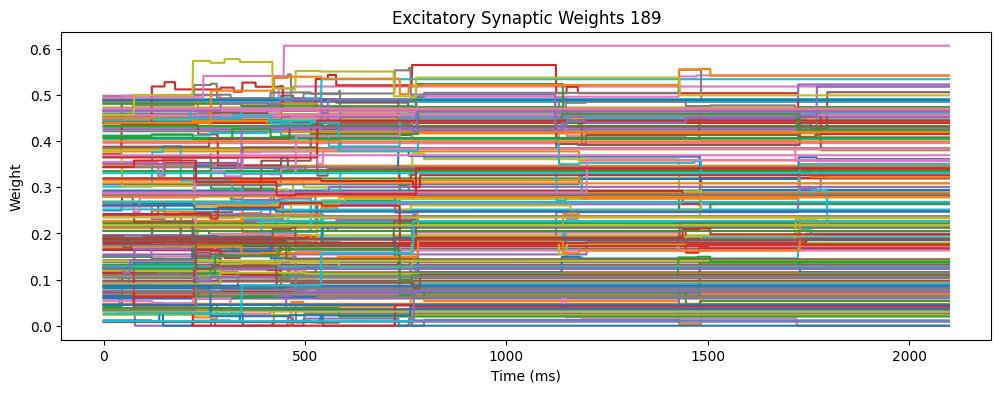

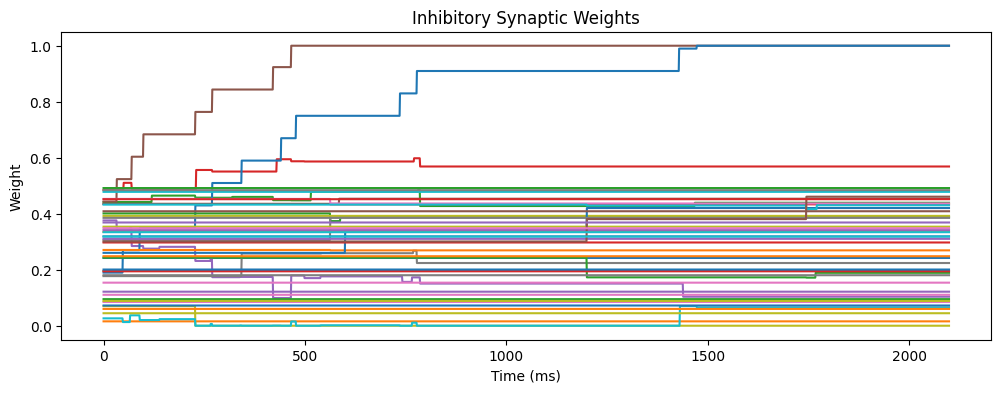

In [547]:

figure(figsize=(12, 4))
for i in range(len(weight_monitor_exc.w)):  
    plot(weight_monitor_exc.t/ms, weight_monitor_exc.w[i], label=f'Excitatory synapse {i}')
    xlabel('Time (ms)')
    ylabel('Weight')
    title(F'Excitatory Synaptic Weights {i}')
show()


figure(figsize=(12, 4))
for i in range(len(weight_monitor_inh.w)):
    plot(weight_monitor_inh.t/ms, weight_monitor_inh.w[i], label=f'Inhibitory synapse {i}')
xlabel('Time (ms)')
ylabel('Weight')
title('Inhibitory Synaptic Weights')

show()



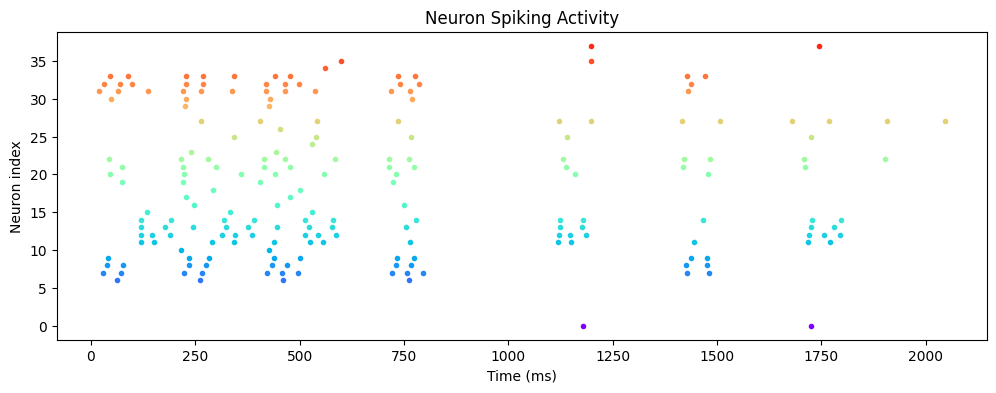

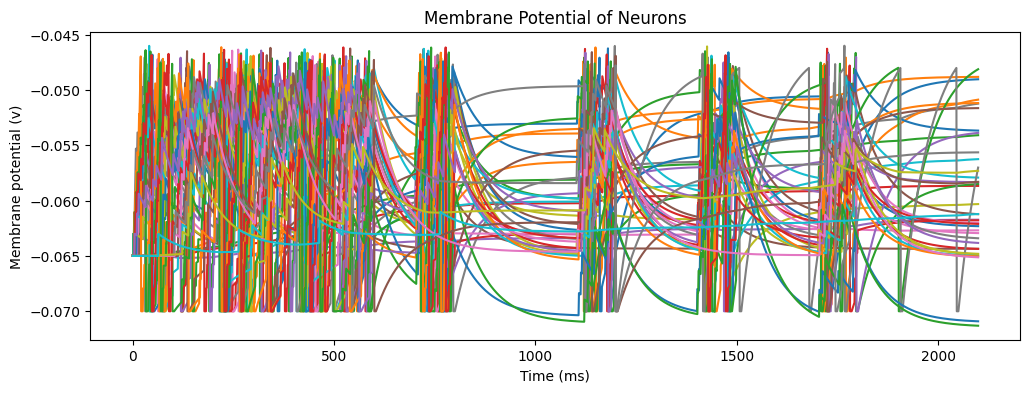

In [548]:
figure(figsize=(12, 4))
colors = matplotlib.cm.rainbow(np.linspace(0, 1, N))

for i in range(N_total):
    neuron_spikes = spike_monitor.t[spike_monitor.i == i]
    plt.plot(neuron_spikes/ms, [i]*len(neuron_spikes), '.', color=colors[i], label=f'Neuron {i}')
xlabel('Time (ms)')
ylabel('Neuron index')
title('Neuron Spiking Activity')
show()


figure(figsize=(12, 4))
for i in range(len(voltage_monitor.v)):

    plot(voltage_monitor.t/ms, voltage_monitor.v[i], label=f'Neuron {i}')
    xlabel('Time (ms)')
    ylabel('Membrane potential (v)')
    title('Membrane Potential of Neurons')
show()

# Network Visualization II

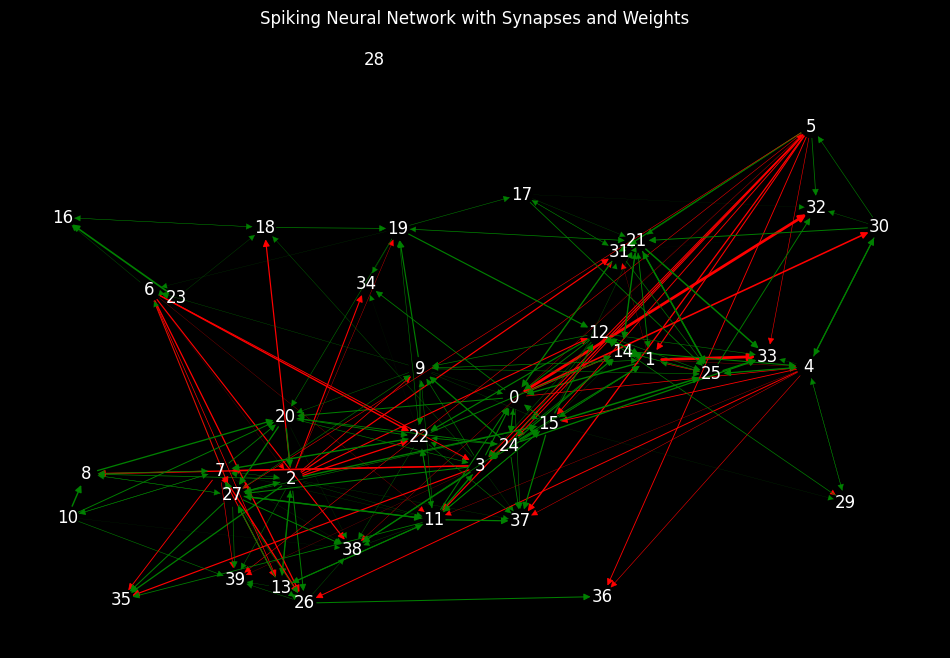

In [549]:
import networkx as nx
neuron_positions = [(G.x[i], G.y[i]) for i in range(N)]

G_graph = nx.DiGraph()

for i, pos in enumerate(neuron_positions):
    G_graph.add_node(i, pos=pos)

#Excitatory Edges
for i, j in zip(S_exc.i[:], S_exc.j[:]):
    G_graph.add_edge(i, j, weight=S_exc.w[i, j], color = 'g')

#Inhibitory Edges
for i, j in zip(S_inh.i[:], S_inh.j[:]):
    G_graph.add_edge(i, j, weight=S_inh.w[i, j], color='r')

pos = nx.get_node_attributes(G_graph, 'pos')
edges = G_graph.edges(data=True)

fig = plt.figure(figsize=(12, 8), )
nx.draw_networkx_nodes(G_graph, pos, node_size=500,node_color=(0, 0, 0, 0))
nx.draw_networkx_labels(G_graph, pos, font_size=12, font_family="sans-serif",font_color='white')

for (u, v, d) in edges:
    width = d['weight'] * 2 
    color = d.get('color', 'b')  # Green for excitatory, Red for inhibitory
    nx.draw_networkx_edges(G_graph, pos, edgelist=[(u, v)], width=width, edge_color=color)

plt.title('Spiking Neural Network with Synapses and Weights', color = 'white')
fig.patch.set_facecolor('black')
plt.axis('off')
plt.show()

# Extended Network in 3D Space

In [550]:
start_scope()
N = 40

#Neuron Group Parameters
tau = 70*ms
v_rest = -65*mV
v_reset = -70*mV
v_threshold = -48*mV
refractory_period = 5*ms

# LIF equation
eqs = '''
dv/dt = (v_rest - v + I) / tau : volt (unless refractory)
I : volt
x : metre
y : metre
z : metre
'''



N_excitatory = int(0.8*N)
N_inhibitory = int(0.2*N)
N_total = N_excitatory + N_inhibitory

G = NeuronGroup(N_total, model=eqs, threshold='v > v_threshold', reset='v = v_reset',
                refractory=refractory_period, method='exact')
G.v = v_rest
G.I = 0*mV
neuron_spacing = 5*N * metre


np.random.seed(2)

#Random Spherical Coordinates
theta = np.arccos(1 - 2 * np.random.rand(N_total))  
phi = 2 * np.pi * np.random.rand(N_total) 

neuron_positions_x = neuron_spacing * np.sin(theta) * np.cos(phi)
neuron_positions_y = neuron_spacing * np.sin(theta) * np.sin(phi)
neuron_positions_z = neuron_spacing * np.cos(theta)

width = max(neuron_positions_x)

height = max(neuron_positions_y)
G.x = neuron_positions_x
G.y = neuron_positions_y
G.z = neuron_positions_z

#Excitatory and Inhibitory Neuron Split
exc_neurons = G[:N_excitatory]
inh_neurons = G[N_excitatory:]


#STDP Parameters
tau_stdp = 15*ms
Aplus = 0.08
Aminus = -Aplus

#STDP Equation
stdp_eqs = '''
w : 1
dApre/dt = -Apre / tau_stdp : 1 (event-driven)
dApost/dt = -Apost / tau_stdp : 1 (event-driven)
'''

pre_eqs_exc = '''
I_post += w*mV
Apre += Aplus
w = clip(w + Apost, 0, 1)
'''
post_eqs_exc = '''
Apost += Aminus
w = clip(w + Apre, 0, 1)
'''

pre_eqs_inh = '''
I_post -= w*mV
Apre += Aplus
w = clip(w + Apost, 0, 1)
'''
post_eqs_inh = '''
Apost += Aminus
w = clip(w + Apre, 0, 1)
'''


def connection_probability(x_pre, y_pre,z_pre, x_post, y_post, z_post, width):
    return np.exp(-((x_pre - x_post)**2 + (y_pre - y_post)**2+(z_pre - z_post)**2) / (width**2))

conn_matrix_exc = np.zeros((N_excitatory, N_total))

for i in range(N_excitatory):
    for j in range(N_total):
        conn_matrix_exc[i, j] = connection_probability(G.x[i], G.y[i], G.z[i], G.x[j], G.y[j],G.z[j], width)
S_exc = Synapses(exc_neurons, G, model=stdp_eqs, on_pre=pre_eqs_exc, on_post=post_eqs_exc)
for i in range(N_excitatory):
    for j in range(N_total):
        if np.random.rand() < conn_matrix_exc[i, j]:
            if i != j: 
                S_exc.connect(i=i, j=j)
S_exc.w = '0.36*rand()'


conn_matrix_inh = np.zeros((N_inhibitory, N_total))
for i in range(N_inhibitory):
    for j in range(N_total):
        conn_matrix_inh[i, j] = connection_probability(G.x[N_excitatory + i], G.y[N_excitatory + i],G.z[N_excitatory + i] , G.x[j], G.y[j], G.z[j], width)

S_inh = Synapses(inh_neurons, G, model=stdp_eqs, on_pre=pre_eqs_inh, on_post=post_eqs_inh)
for i in range(N_inhibitory):
    for j in range(N_total):
        if np.random.rand() < conn_matrix_inh[i, j]:
            if i != j: 
                S_inh.connect(i=i, j=j)
S_inh.w = '0.3*rand()'



# Input Preprocessing III

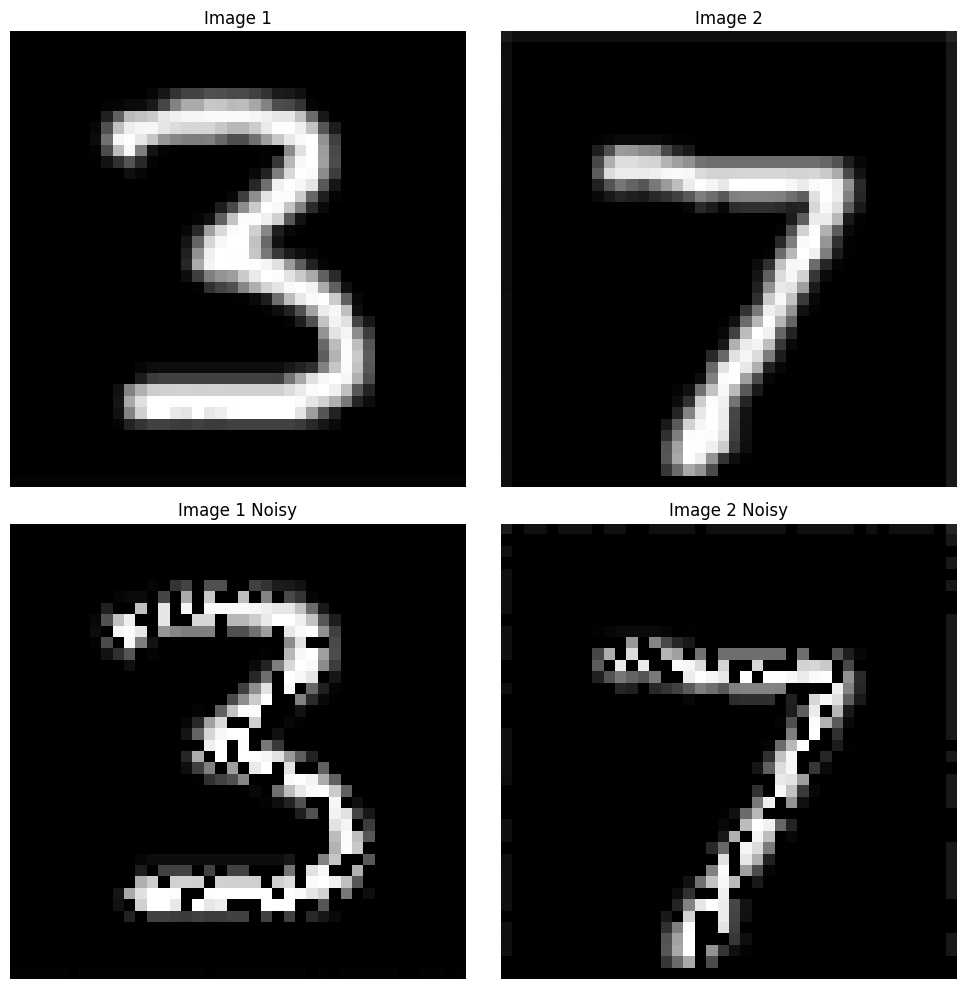

In [551]:
def preprocess_image(image_path, size):
    image = Image.open(image_path).convert('L') 
    image = image.resize(size)  
    image_array = np.array(image)
    image_array = image_array / 255.0  
    return image_array

def preprocess_image_noisy(image_path, size,salt_prob, pepper_prob):
    image = Image.open(image_path).convert('L') 
    image = image.resize(size)  
    image_array = np.array(image)
    random_matrix = np.random.rand(*image_array.shape[:2])

    salt_mask = random_matrix < salt_prob
    image_array[salt_mask] = 0

    image_array = image_array / 255.0  
    return image_array

defaultclock.dt = 1*ms
salt_prob = 0.3
pepper_prob = 0.0 

image_size = (N, N) 
image1_array = preprocess_image('3.png', image_size)
image2_array = preprocess_image('7.png', image_size)
image3_array = preprocess_image_noisy('3.png', image_size ,salt_prob, pepper_prob)
image4_array = preprocess_image_noisy('7.png', image_size ,salt_prob, pepper_prob)

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0, 0].imshow(image1_array, cmap='gray')
axs[0, 0].set_title("Image 1")
axs[0, 0].axis('off')
axs[0, 1].imshow(image2_array, cmap='gray')
axs[0, 1].set_title("Image 2")
axs[0, 1].axis('off')
axs[1, 0].imshow(image3_array, cmap='gray')
axs[1, 0].set_title("Image 1 Noisy")
axs[1, 0].axis('off')
axs[1, 1].imshow(image4_array, cmap='gray')
axs[1, 1].set_title("Image 2 Noisy")
axs[1, 1].axis('off')
plt.tight_layout()
plt.show()

def aggregate_image(image_array):
    assert image_array.shape == (N, N), "Image must be 10x10"
    aggregated_values = np.mean(image_array.reshape(N, N), axis=1)
    return aggregated_values

def image_to_spike_times(aggregated_values, max_firing_rate, duration):
    indices = []
    times = []
    for i, value in enumerate(aggregated_values):

        num_spikes = int(value * max_firing_rate * duration)
        np.set_printoptions(precision=3)

        if num_spikes > 0:
            spike_times = np.round(np.random.uniform(low = 0.001, high=duration, size=num_spikes),3)
            spike_times = np.unique(spike_times)
            for t in spike_times:
                
                indices.append(i)
                times.append(t)
    return indices, times


aggregated1_values = aggregate_image(image1_array)
aggregated2_values = aggregate_image(image2_array)
aggregated3_values = aggregate_image(image3_array)
aggregated4_values = aggregate_image(image4_array)
#Spike Time Parameters
max_firing_rate = 1000 * Hz
duration = 100 * ms

indices1, times1 = image_to_spike_times(aggregated1_values, max_firing_rate, duration)
indices2, times2 = image_to_spike_times(aggregated2_values, max_firing_rate, duration)
indices_noisy1, times_noisy1 = image_to_spike_times(aggregated3_values, max_firing_rate, duration)
indices_noisy2, times_noisy2 = image_to_spike_times(aggregated4_values, max_firing_rate, duration)

for i in range(len(times2)):
    times2[i] = times2[i] + 0.1
times3= []
indices3 = []
for i in range(len(times1)):
    times3.append(times1[i]+0.2)
    indices3.append(indices1[i])
times4= []
indices4 = []
for i in range(len(times2)):
    times4.append(times2[i]+0.2)
    indices4.append(indices2[i])
times5= []
indices5 = []
for i in range(len(times1)):
    times5.append(times1[i]+0.4)
    indices5.append(indices1[i])
times6= []
indices6 = []
for i in range(len(times2)):
    times6.append(times2[i]+0.4)
    indices6.append(indices2[i])
times7= []
indices7 = []
for i in range(len(times1)):
    times7.append(times1[i]+0.8)
    indices7.append(indices1[i])
times8= []
indices8= []
for i in range(len(times2)):
    times8.append(times2[i]+1.0)
    indices8.append(indices2[i])

times9= []
indices9 = []
for i in range(len(times1)):
    times9.append(times1[i]+0.7)
    indices9.append(indices1[i])
times10= []
indices10= []
for i in range(len(times2)):
    times10.append(times2[i]+0.7)
    indices10.append(indices2[i])

times11= []
indices11 = []
for i in range(len(times_noisy1)):
    times11.append(times_noisy1[i]+1.4)
    indices11.append(indices_noisy1[i])
times12= []
indices12= []
for i in range(len(times_noisy2)):
    times12.append(times_noisy2[i]+1.7)
    indices12.append(indices_noisy2[i])

#Input Group
input_group = SpikeGeneratorGroup(N, indices1+indices2+indices3+indices4+indices5+indices6+indices9+indices8+indices11+indices12, (times1+ times2+times3+ times4+times5 + times6+times9+times8+times11+times12) * second)


# Simulation III

In [552]:
input_syn = Synapses(input_group, G, on_pre='v += 2*mV')
input_syn.connect(j='i')

weight_monitor_exc = StateMonitor(S_exc, 'w', record=True)
weight_monitor_inh = StateMonitor(S_inh, 'w', record=True)
spike_monitor = SpikeMonitor(G)
weight_monitor_exc = StateMonitor(S_exc, 'w', record=True)
weight_monitor_inh = StateMonitor(S_inh, 'w', record=True)
spike_monitor = SpikeMonitor(G)
voltage_monitor = StateMonitor(G, 'v', record=True)  

run(2100*ms)

WARNING    'v' is an internal variable of group 'neurongroup_1', but also exists in the run namespace with the value 25. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'v' is an internal variable of group 'synapses_5', but also exists in the run namespace with the value 25. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


# Result Plots III

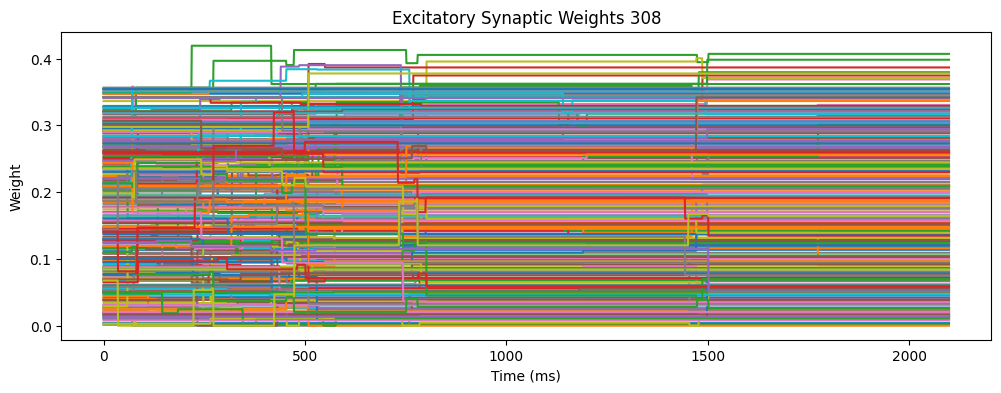

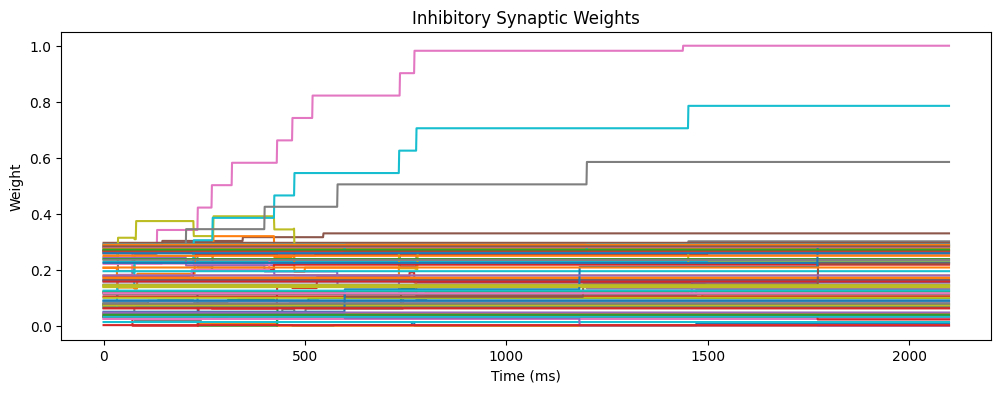

In [553]:

figure(figsize=(12, 4))
for i in range(len(weight_monitor_exc.w)):  
    plot(weight_monitor_exc.t/ms, weight_monitor_exc.w[i], label=f'Excitatory synapse {i}')
    xlabel('Time (ms)')
    ylabel('Weight')
    title(F'Excitatory Synaptic Weights {i}')
show()


figure(figsize=(12, 4))
for i in range(len(weight_monitor_inh.w)):
    plot(weight_monitor_inh.t/ms, weight_monitor_inh.w[i], label=f'Inhibitory synapse {i}')
xlabel('Time (ms)')
ylabel('Weight')
title('Inhibitory Synaptic Weights')

show()

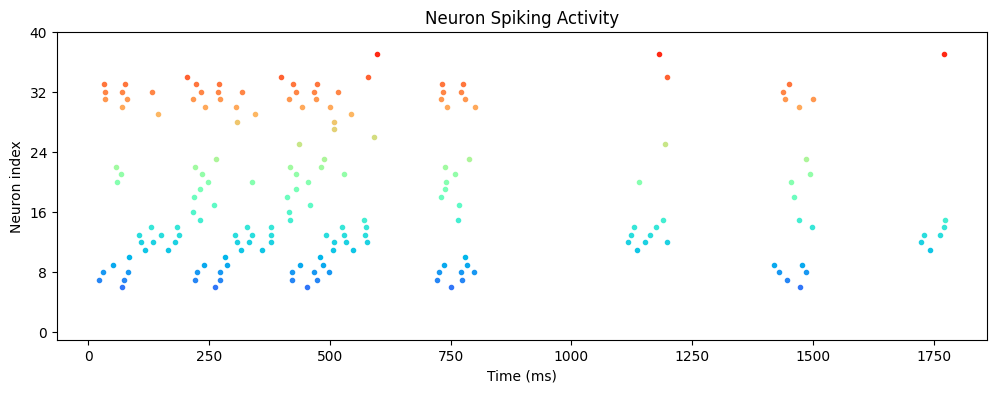

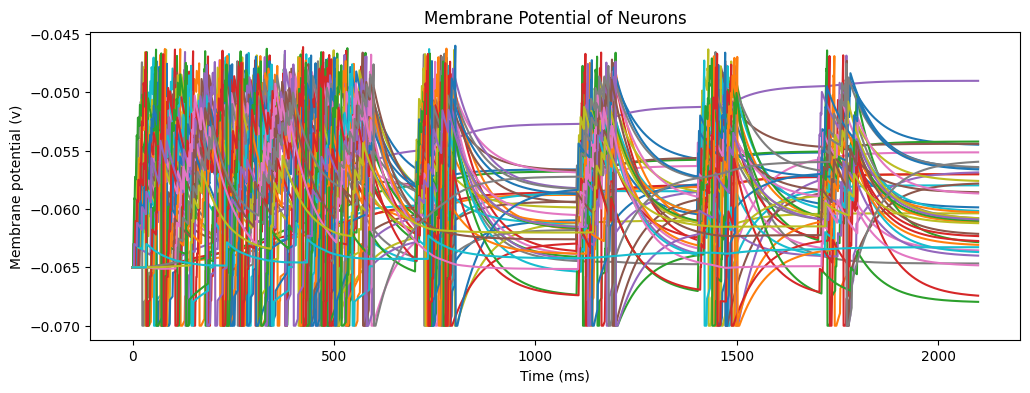

In [554]:
figure(figsize=(12, 4))
colors = matplotlib.cm.rainbow(np.linspace(0, 1, N))

for i in range(N_total):
    neuron_spikes = spike_monitor.t[spike_monitor.i == i]
    plt.plot(neuron_spikes/ms, [i]*len(neuron_spikes), '.', color=colors[i], label=f'Neuron {i}')
xlabel('Time (ms)')
ylim(-1,N)
ylabel('Neuron index')
yticks([0,N/5,2*N/5,3*N/5,4*N/5,N])
title('Neuron Spiking Activity')
show()


figure(figsize=(12, 4))
for i in range(len(voltage_monitor.v)):
    
    plot(voltage_monitor.t/ms, voltage_monitor.v[i], label=f'Neuron {i}')
    xlabel('Time (ms)')
    ylabel('Membrane potential (v)')
    title('Membrane Potential of Neurons')

show()

# Network Visualization III

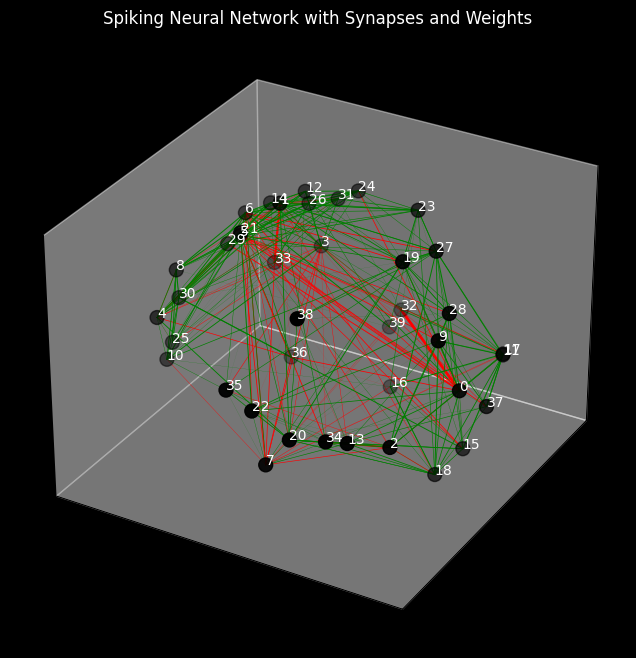

In [555]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx

neuron_positions = [(G.x[i], G.y[i], G.z[i]) for i in range(N)]

G_graph = nx.DiGraph()

for i, pos in enumerate(neuron_positions):
    G_graph.add_node(i, pos=pos)

#Excitatory Edges
for i, j in zip(S_exc.i[:], S_exc.j[:]):
    G_graph.add_edge(i, j, weight=S_exc.w[i, j], color='g')

#Inhibitory Edges
for i, j in zip(S_inh.i[:], S_inh.j[:]):
    G_graph.add_edge(i, j, weight=S_inh.w[i, j], color='r')

pos = nx.get_node_attributes(G_graph, 'pos')
edges = G_graph.edges(data=True)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

xs = [pos[i][0] for i in pos]
ys = [pos[i][1] for i in pos]
zs = [pos[i][2] for i in pos]
ax.scatter(xs, ys, zs, s=100, c='k')

#Labeling
for i in pos:
    ax.text(pos[i][0], pos[i][1], pos[i][2], str(i), color='white')

for (u, v, d) in edges:
    x = [pos[u][0], pos[v][0]]
    y = [pos[u][1], pos[v][1]]
    z = [pos[u][2], pos[v][2]]
    width = d['weight'] * 2  
    color = d.get('color', 'b')  #Green for excitatory, Red for inhibitory
    ax.plot(x, y, z, color=color, linewidth=width)

ax.set_title('Spiking Neural Network with Synapses and Weights', color='white')
fig.patch.set_facecolor('black')
ax.set_facecolor('black')
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

#Hiding Grid Lines
ax.grid(False)

ax.set_xlabel('')
ax.set_ylabel('')
ax.set_zlabel('')




ax.set_title('Spiking Neural Network with Synapses and Weights', color='white')

plt.show()
plt.show()
